In [93]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools
import matplotlib.pyplot as plt 
import os
import io
%matplotlib inline

In [94]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller

In [95]:
import warnings
warnings.filterwarnings("ignore")

In [96]:
#from google.colab import drive
#drive.mount('/content/drive')

In [97]:
#os.chdir('/content/drive/My Drive/my projects/')

In [98]:
df =pd.read_csv('BSE_Data.csv')
df.head()

,date,close
0,01-Jan-20,41306.02
1,02-Jan-20,41626.64
2,03-Jan-20,41464.61
3,06-Jan-20,40676.63
4,07-Jan-20,40869.47


In [99]:
df.shape

(313, 2)

In [100]:
df_con = df[['close']] #creating new dataframe with only "close" column

In [101]:
df_con.dtypes

close    float64
dtype: object

In [102]:
#Creating train and test set 
#train - 0:313*0.80 - 0 to 249
#test - 313*0.80 - 250 to 313
train=df_con[0:int(len(df_con)*0.80)] 
test=df_con[int(len(df_con)*0.80):]

<AxesSubplot:title={'center':'BSE'}>

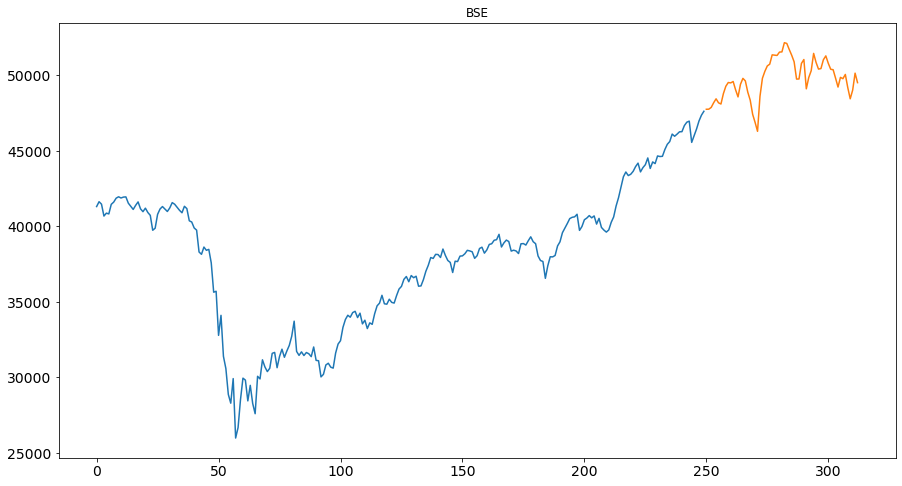

In [103]:
#Plot data
train.close.plot(figsize=(15,8), title= 'BSE', fontsize=14)
test.close.plot(figsize=(15,8), title= 'BSE', fontsize=14)

In [104]:
f_train = train.close

In [105]:
# Define the p, d and q parameters to take any value between 0 and 2
# For the initial model, you can take any values from 0 to 3. Kind of permutation and combination values, for all 3 components
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [106]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

In [107]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(f_train,
                                             order = param,
                                             seasonal_order = param_seasonal)
            results = temp_model.fit()

           
            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            #here, it gives initially p, d and q as 0 and trying to find the best aic value, once it finds the aic value, it 
            # changes different combinations like ex 0, 1, 0 then it tries all the combinations. With the best aic value, it 
            #gives output
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}0 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 0, 1)x(2, 2, 1, 7)0 model - AIC:12.0


In [108]:
#the output is given to this model to the training model, where p,d, q values are 1,1,0 along with seasonality values
#from the model
best_model = sm.tsa.statespace.SARIMAX(f_train,
                                      order=(1, 1, 0),
                                      seasonal_order=(2, 2, 2, 7))
best_results = best_model.fit()

In [109]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                       SARIMAX Results                                        
Dep. Variable:                                  close   No. Observations:                  250
Model:             SARIMAX(1, 1, 0)x(2, 2, [1, 2], 7)   Log Likelihood               -1946.665
Date:                                Fri, 30 Apr 2021   AIC                           3905.329
Time:                                        21:03:06   BIC                           3926.087
Sample:                                             0   HQIC                          3913.698
                                                - 250                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.045     -0.489      0.625      -0.110       0.066
ar.

In [110]:
test.shape #313 - 250

(63, 1)

In [111]:
predict= best_results.get_forecast(steps=63, alpha=0.1) #forecasting into the future, next 63 steps forward

In [112]:
train.tail()

,close
245,46006.69
246,46444.18
247,46973.54
248,47353.75
249,47613.08


In [113]:
test['forecast'] = predict.predicted_mean # adding "forecast" column which we will generate.

In [114]:
test

,close,forecast
250,47746.22,47749.089982
251,47751.33,46483.099511
252,47868.98,46627.620868
253,48176.80,47026.435845
254,48437.78,47495.982558
...,...,...
308,49180.31,42761.864432
309,48440.12,43186.107880
310,49008.50,43776.693360
311,50136.58,44364.524295


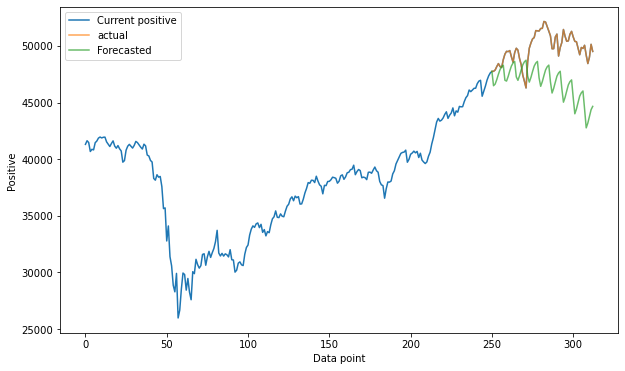

In [115]:
axis = df_con['close'].plot(label='Current positive', figsize=(10, 6))
test['close'].plot(ax=axis, label='actual', alpha=0.7)
test['forecast'].plot(ax=axis, label='Forecasted', alpha=0.7)
axis.set_xlabel('Data point')
axis.set_ylabel('Positive')
plt.legend(loc='best')
plt.show()
plt.close()

In [116]:
y_true = test['close']
y_pred = test['forecast']

In [117]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [118]:
mean_absolute_percentage_error(y_true,y_pred)

6.277396112271812